In [1]:
# Description:
#   Exercise3 notebook.
#
# Copyright (C) 2018 Santiago Cortes, Juha Ylioinas
#
# This software is distributed under the GNU General Public 
# Licence (version 2 or later); please refer to the file 
# Licence.txt, included with the software, for details.
# Preparations
from skimage.io import imread
from skimage.transform import resize
import numpy as np
from numpy.fft import fftshift, fft2
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, median_filter, map_coordinates
from scipy.misc import imresize
from scipy.ndimage.filters import convolve as conv2
from scipy.ndimage.filters import convolve1d as conv1

from utils import rgb2gray, imnoise, add_gaussian_noise, gaussian2, affinefit

# CS-E4850 Computer Vision Exercise Round 3
<br> Note that (1) you are not supposed to change anything in the utils.py

## Exercise 1 - Image denoising

In this exercise you will need to denoise the two example images using<br>
a) Gaussian filtering, <br>
b) median filtering, and <br>
c) bilateral filtering (the latter two are explained in Section 3.3.1 of Szeliski’s book).

In [2]:
## Load test images.
## Note: Must be double precision in the interval [0,1].
img_mat = imread('./assets/department2.jpg')
img_mat.shape
# M x N x 3 matrix (RGB)

(480, 640, 3)

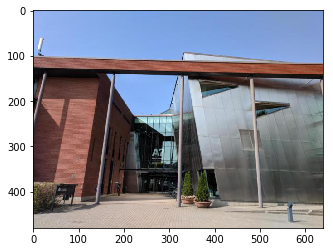

In [3]:
plt.imshow(img_mat)

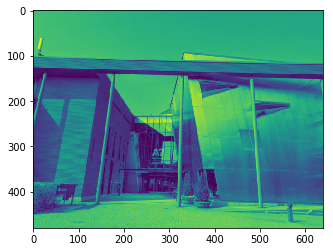

In [4]:
im = rgb2gray(img_mat)/255
plt.imshow(im)

In [5]:
im = resize(im, (256, 256))
# reshape to 256 x 256
im.shape

/home/adam/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/adam/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(256, 256)

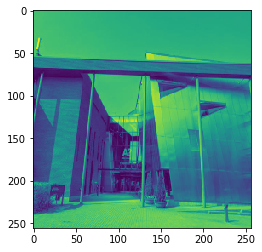

In [6]:
plt.imshow(im)

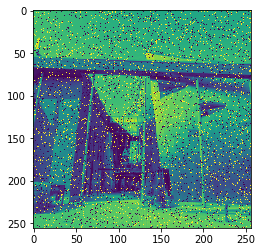

In [7]:
# salt-and-pepper noise generator
def imnoise(img, mode, prob):
    imgn = img.copy()
    if mode == 'salt & pepper':
        assert (prob >= 0 and prob <= 1), "prob must be a scalar between 0 and 1"
        h, w = imgn.shape
        prob_sp = np.random.rand(h, w)
        imgn[prob_sp < prob] = 0
        imgn[prob_sp > 1 - prob] = 1
        

    return imgn
# Add noise
## "salt and pepper" noise
imns = imnoise(im, 'salt & pepper', 0.05)
plt.imshow(imns)

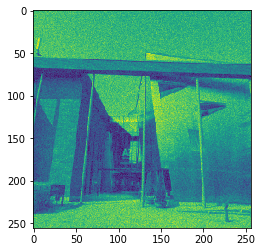

In [8]:
## zero-mean gaussian noise
imng = im + 0.05*np.random.randn(im.shape[0],im.shape[1])
plt.imshow(imng)

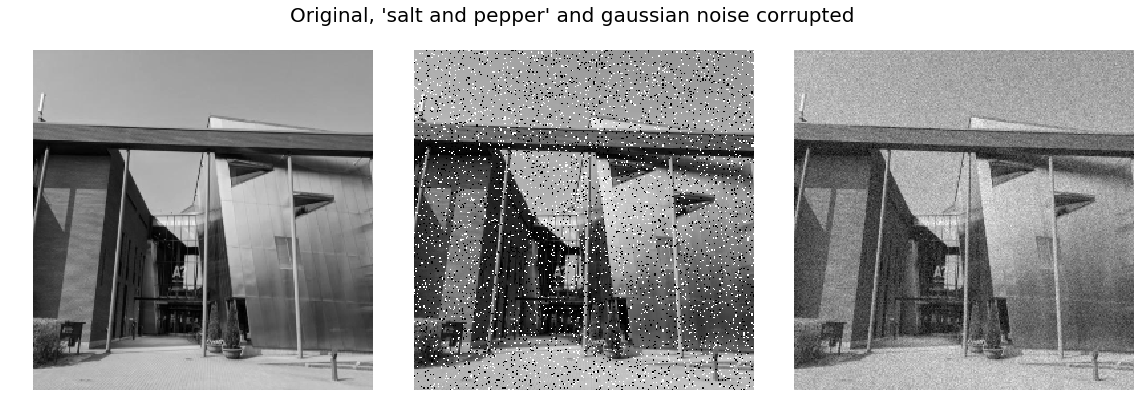

In [9]:
# Display original and noise corrupted images
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,8))
ax = axes.ravel()
ax[0].imshow(im, cmap='gray')
ax[0].axis('off')
ax[1].imshow(imns, cmap='gray')
ax[1].axis('off')
ax[2].imshow(imng, cmap='gray')
ax[2].axis('off')
plt.tight_layout()
plt.suptitle("Original, 'salt and pepper' and gaussian noise corrupted", fontsize=20)
plt.subplots_adjust(top=1.2)
plt.show()

# a) Gaussian filtering
$$G_\sigma(x,y) = \frac{1}{2 \pi \sigma ^2} \exp{(-\frac{x^2+y^2}{2 \sigma^2})}$$

In [10]:
# what meshgrid does

xvalues = np.array([0, 1, 2, 3, 4]);
yvalues = np.array([0, 1, 2, 3, 4]);

print("0:\n", np.meshgrid(xvalues, yvalues)[0])
print("\n1:\n", np.meshgrid(xvalues, yvalues)[1])

0:
 [[0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]]

1:
 [[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]


In [11]:
# 2d Gaussian filter
def gaussian2(sigma, N=None):
    if N is None:
        N = 2*np.maximum(4, np.ceil(6*sigma))+1

    k = (N - 1) / 2.
    xv, yv = np.meshgrid(np.arange(-k, k+1), np.arange(-k, k+1))

    # 2D gaussian filter    
    g = 1/(2 * np.pi * sigma**2) * np.exp(-(xv**2 + yv**2) / (2 * sigma ** 2))
    # 1st order derivatives
    gx = -xv / (2 * np.pi * sigma**4) * np.exp(-(xv**2 + yv**2) / (2 * sigma ** 2))
    gy = -yv / (2 * np.pi * sigma**4) * np.exp(-(xv**2 + yv**2) / (2 * sigma**2)) 
    # 2nd order derivatives
    gxx = (-1 + xv**2 / sigma**2) * np.exp(-(xv**2 + yv**2) / (2*sigma**2)) / (2 * np.pi * sigma**4)
    gyy = (-1 + yv**2 / sigma**2) * np.exp(-(xv**2 + yv**2) / (2*sigma**2)) / (2 * np.pi * sigma**4)
    gxy = (xv * yv) / (2 * np.pi * sigma**6) * np.exp(-(xv**2 + yv**2) / (2*sigma**2))    

    return g, gx, gy, gxx, gyy, gxy

In [12]:
## Apply Gaussian filter of std 2.5 
sigmad = 2.5
g,_,_,_,_,_, = gaussian2(sigmad)

In [13]:
g.shape

(31, 31)

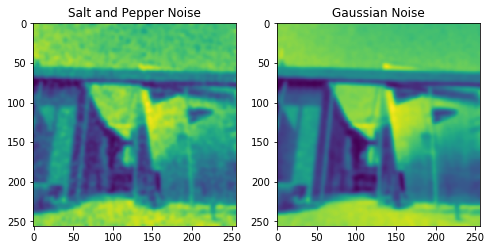

In [14]:
gflt_imns = conv2(imns, g, mode='reflect')
gflt_imng = conv2(imng, g, mode='reflect')


fig = plt.figure(figsize=(8, 6)) 
plt.subplot(1, 2, 1)
plt.imshow(gflt_imns)
plt.title("Salt and Pepper Noise")

plt.subplot(1, 2, 2)
plt.imshow(gflt_imng)
plt.title("Gaussian Noise")
plt.show()

In [15]:
def gaussian1d(sigma, N=None):
    if N is None:
        N = 2*np.maximum(4, np.ceil(6*sigma))+1

    k = (N - 1) / 2.
    x = np.arange(-k, k+1)

    # 1D gaussian x filter
    g = 1/(np.sqrt(2 * np.pi * sigma**2)) * np.exp(-(x**2) / (2 * sigma ** 2)) 
    return g

In [16]:
## Apply Gaussian filter of std 2.5 
sigmad = 2.5
g_1d = gaussian1d(sigmad)

In [17]:
## Instead of directly filtering with g, make a separable implementation
## where you use horizontal and vertical 1D convolutions
## That is, replace the above two lines, you can use conv1 instead
## The result should not change.

##--your-code-starts-here--##

##--your-code-ends-here--##
gflt_imns_x = conv1(imns, g_1d, mode="reflect", axis=0)
gflt_imns_xy = conv1(gflt_imns_x, g_1d, mode='reflect', axis=1)

gflt_imns_y = conv1(imns, g_1d, mode="reflect", axis=1)
gflt_imns_yx = conv1(gflt_imns_y, g_1d, mode='reflect', axis=0)

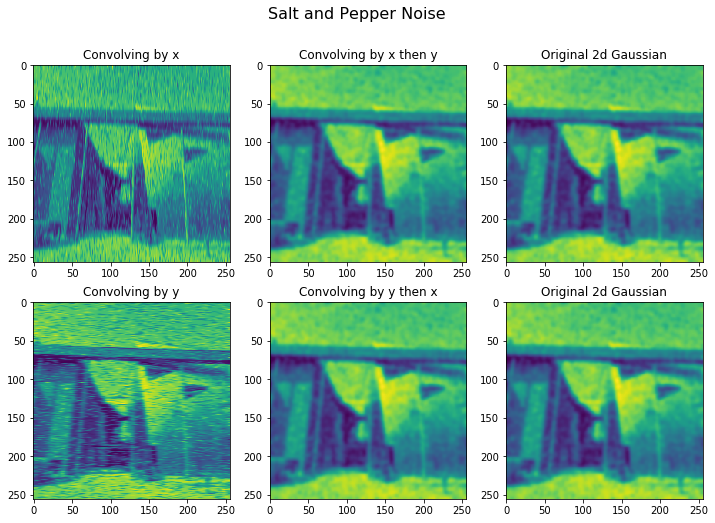

In [18]:
fig, ax = plt.subplots(2, 3, figsize = (12, 8))
fig.suptitle("Salt and Pepper Noise", fontsize=16)

ax[0,0].imshow(gflt_imns_x)
ax[0,0].set_title("Convolving by x")

ax[0,1].imshow(gflt_imns_xy)
ax[0,1].set_title("Convolving by x then y")

ax[0,2].imshow(gflt_imns)
ax[0,2].set_title("Original 2d Gaussian")

ax[1,0].imshow(gflt_imns_y)
ax[1,0].set_title("Convolving by y")

ax[1,1].imshow(gflt_imns_yx)
ax[1,1].set_title("Convolving by y then x")

ax[1,2].imshow(gflt_imns)
ax[1,2].set_title("Original 2d Gaussian")
plt.show()

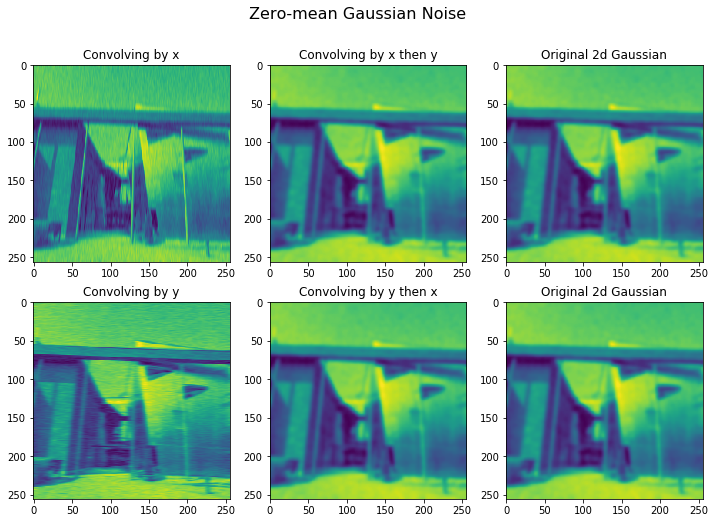

In [19]:
## Apply Gaussian filter of std 2.5 
sigmad = 2.5
g_1d = gaussian1d(sigmad)

gflt_imng_x = conv1(imng, g_1d, mode="reflect", axis=0)
gflt_imng_xy = conv1(gflt_imng_x, g_1d, mode='reflect', axis=1)

gflt_imng_y = conv1(imng, g_1d, mode="reflect", axis=1)
gflt_imng_yx = conv1(gflt_imng_y, g_1d, mode='reflect', axis=0)

fig, ax = plt.subplots(2, 3, figsize = (12, 8))
fig.suptitle("Zero-mean Gaussian Noise", fontsize=16)

ax[0,0].imshow(gflt_imng_x)
ax[0,0].set_title("Convolving by x")

ax[0,1].imshow(gflt_imng_xy)
ax[0,1].set_title("Convolving by x then y")

ax[0,2].imshow(gflt_imng)
ax[0,2].set_title("Original 2d Gaussian")

ax[1,0].imshow(gflt_imng_y)
ax[1,0].set_title("Convolving by y")

ax[1,1].imshow(gflt_imng_yx)
ax[1,1].set_title("Convolving by y then x")

ax[1,2].imshow(gflt_imng)
ax[1,2].set_title("Original 2d Gaussian")
plt.show()

# b) Median filtering

In [20]:
## Apply median filtering, use neighborhood size 5x5

##--your-code-starts-here--##
#plt.imshow(imng)

def median_filter(img, size=(3,3)):
    assert size[0]%2==1 and size[1]%2==1 # odd number please
    img = img.copy()
    start_m = int(size[0]/2)
    start_n = int(size[1]/2)
    for m in range(start_m, img.shape[0]-start_m):
        for n in range(start_n, img.shape[1]-start_n):
            window = [img[m+k][n+l] for k in range(-1*start_m, start_m+1) for l in range(-1*start_n, start_n+1)]
            img[m,n] = np.median(window)
    return img
##--your-code-ends-here--##

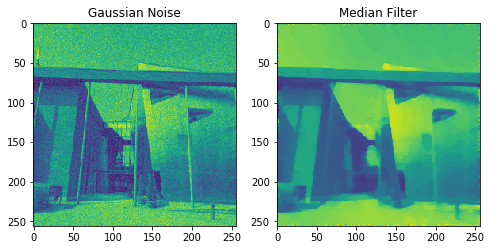

In [21]:
median_filter_imng = median_filter(imng, (5,5))
fig, ax = plt.subplots(1, 2, figsize = (8, 4))

ax[0].imshow(imng)
ax[0].set_title("Gaussian Noise")

ax[1].imshow(median_filter_imng)
ax[1].set_title("Median Filter")

plt.show()

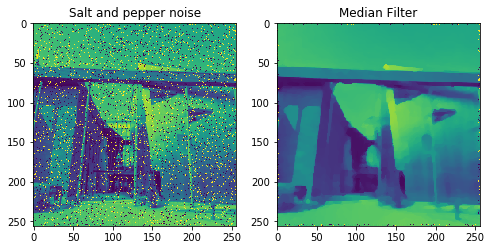

In [22]:
median_filter_imns = median_filter(imns, (5,5))
fig, ax = plt.subplots(1, 2, figsize = (8, 4))

ax[0].imshow(imns)
ax[0].set_title("Salt and pepper noise")

ax[1].imshow(median_filter_imns)
ax[1].set_title("Median Filter")

plt.show()

# c) Bilateral filtering

What if we were to combine the idea of a weighted filter kernel with a better version of outlier
rejection? What if instead of rejecting a fixed percentage α, we simply reject (in a soft way)
pixels whose values differ too much from the central pixel value? This is the essential idea in
bilateral filtering,

In the bilateral filter, the output pixel value depends on a weighted combination of neigh-
boring pixel values

output pixel: $$g(i, j) = \frac{\sum_{k,l} f(k,l) w(i, j, k, l)}{ \sum_{k,l} w(i, j, k, l)}$$

- i, j is location of current pixel
- k, l are the neighbouring pixels

The weighing coefficient here is dependant on the 
- domain kernel
- range kernel

Domain kernel: $$d(i,j,k,l) = \exp (-\frac{(i-k)^2 + (j-l)^2}{2 \sigma_d^2})$$
Which considers the distance distance /influence of neighbouring pixels

Range kernel: $$r(i,j,k,l) =  \exp (- \frac{||f(i,j) - f(k,l)||^2}{2 \sigma_r^2})$$

where we consider the **value** (f is the value of the pixel.)

$$w(i,j,k,l) = \exp (-\frac{(i-k)^2 + (j-l)^2}{2 \sigma_d^2} - \frac{||f(i,j) - f(k,l)||^2}{2 \sigma_r^2})$$

In [23]:
def weighing_coefficient(img, i,j,k,l, sigma_d, sigma_r):
    '''
    i,j: location of pixel to transform
    k,l: location of neighbouring pixel
    
    Returns
        weighing coefficient
    '''
    domain_kernel = np.exp(-1 * ((i-k)**2+(j-l)**2)/ (2 * sigma_d **2))
    range_kernel = np.exp(-1 * np.sqrt( (img[i][j]**2 - img[k][l]**2 )**2) / (2 * sigma_r ** 2))
    return domain_kernel * range_kernel

In [24]:
def bilateral_filter(img, wsize, sigma_d, sigma_r):
    img = img.copy()
    d = int(wsize/2)
    for i in range(d, img.shape[0]-d):
        for j in range(d, img.shape[1]-d):
            sum_of_weights = 0
            sum_of_weighted_pixels = 0
            for steps in range(-1*d, d+1):
                k, l = i+steps, j+steps 
                weights = weighing_coefficient(img, i, j, k, l, sigma_d, sigma_r)
                sum_of_weights += weights
                sum_of_weighted_pixels += img[k][l] * weights
                
            new_pixel = sum_of_weighted_pixels / sum_of_weights
            img[i][j] = new_pixel
    return img

In [25]:
## Apply bilateral filter to each image and (uncomment the function calls once
## its definition is ready)

## You need to implement bilateralfilter function above.
## Use formulas (3.34)-(3.37) from Szeliski's book.
## You may freely decide in which mode ('full', 'valid', or 'same') your
## function runs (only one implementation enough), but note that with 'full' and 'same'
## you need to take care how the borders are handled (padded).

## Set bilateral filter parameters.
wsize = 11
sigma_d = 2.5
sigma_r = 0.1

bflt_imng = bilateral_filter(imng, wsize, sigma_d, sigma_r)

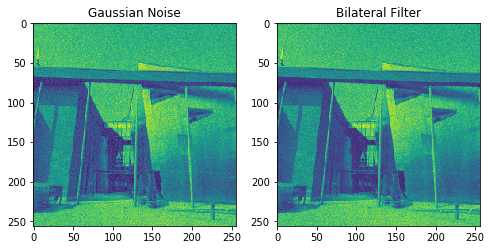

In [26]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))

ax[0].imshow(imng)
ax[0].set_title("Gaussian Noise")

ax[1].imshow(bflt_imng)
ax[1].set_title("Bilateral Filter")

plt.show()

In [27]:
bflt_imns = bilateral_filter(imns, wsize, sigma_d, sigma_r)

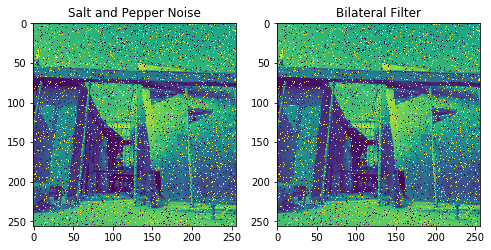

In [28]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))

ax[0].imshow(imns)
ax[0].set_title("Salt and Pepper Noise")

ax[1].imshow(bflt_imns)
ax[1].set_title("Bilateral Filter")

plt.show()

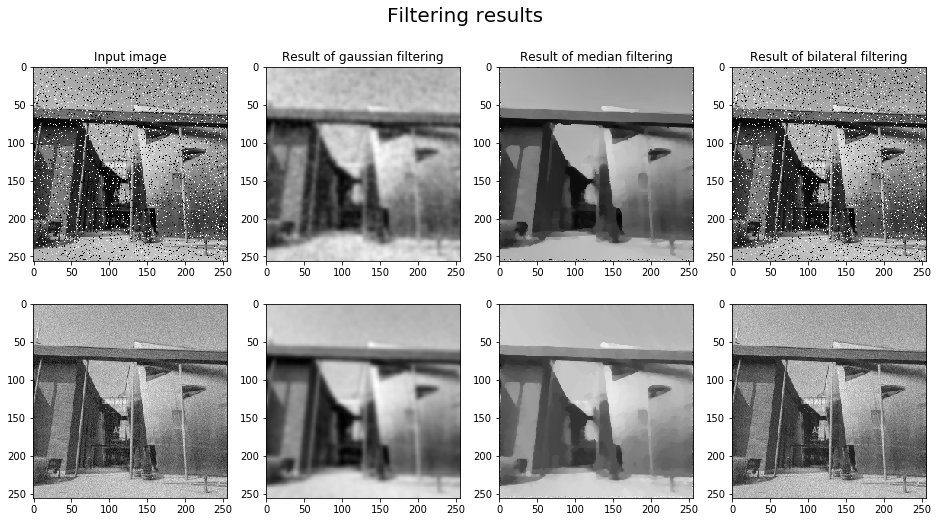

In [29]:
# Display filtering results
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))
ax = axes.ravel()
ax[0].imshow(imns, cmap='gray')
ax[0].set_title("Input image")
ax[1].imshow(gflt_imns, cmap='gray')
ax[1].set_title("Result of gaussian filtering")
ax[2].imshow(median_filter_imns, cmap='gray')
ax[2].set_title("Result of median filtering")
ax[3].imshow(bflt_imns, cmap='gray')
ax[3].set_title("Result of bilateral filtering")
ax[4].imshow(imng, cmap='gray')
ax[5].imshow(gflt_imng, cmap='gray')
ax[6].imshow(median_filter_imng, cmap='gray')
ax[7].imshow(bflt_imng, cmap='gray')
plt.suptitle("Filtering results", fontsize=20)
plt.show()